<a href="https://colab.research.google.com/github/KungFuPanda22/CNN_Devanagiri/blob/master/Dataset_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries
These are all the libraries we need to import

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import tarfile
from six.moves import cPickle as pickle
import time

In [0]:
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler 


#Data Storage

This section of code reads the Devnagiri Dataset and stores it in an array and randomizes it and then standardizes it.

In [0]:
#Extracting Devnagiri Data

num_classes = 18
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract('Train.tar.gz')

Train already present - Skipping extraction of Train.tar.gz.
['Train/character_11_taamatar', 'Train/character_13_daa', 'Train/character_16_tabala', 'Train/character_18_da', 'Train/character_1_ka', 'Train/character_21_pa', 'Train/character_25_ma', 'Train/character_26_yaw', 'Train/character_27_ra', 'Train/character_28_la', 'Train/character_29_waw', 'Train/character_30_motosaw', 'Train/character_32_patalosaw', 'Train/character_33_ha', 'Train/character_3_ga', 'Train/character_4_gha', 'Train/character_6_cha', 'Train/character_8_ja']


In [0]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

#Storing data in NumPy array

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (plt.imread(image_file,0).astype(float)-pixel_depth/2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 1700)

Train/character_11_taamatar.pickle already present - Skipping pickling.
Train/character_13_daa.pickle already present - Skipping pickling.
Train/character_16_tabala.pickle already present - Skipping pickling.
Train/character_18_da.pickle already present - Skipping pickling.
Train/character_1_ka.pickle already present - Skipping pickling.
Train/character_21_pa.pickle already present - Skipping pickling.
Train/character_25_ma.pickle already present - Skipping pickling.
Train/character_26_yaw.pickle already present - Skipping pickling.
Train/character_27_ra.pickle already present - Skipping pickling.
Train/character_28_la.pickle already present - Skipping pickling.
Train/character_29_waw.pickle already present - Skipping pickling.
Train/character_30_motosaw.pickle already present - Skipping pickling.
Train/character_32_patalosaw.pickle already present - Skipping pickling.
Train/character_33_ha.pickle already present - Skipping pickling.
Train/character_3_ga.pickle already present - Skippi

In [0]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, 30600,0)




In [0]:
#Randodmize the Dataset

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)

In [0]:
train_dataset = train_dataset.reshape(train_dataset.shape[0],1024)
sc = StandardScaler()
train_dataset = sc.fit_transform(train_dataset)


In [0]:
train_dataset.shape

(30600, 1024)

# Data Visualization - Principal Component Analysis

First, we apply Principal Component Analysis(PCA) on the dataset. The dataset has 1024 features for each example. For the first step, we try to apply PCA and reduce the no. of components to two. In the second step, we reduce the components to three and make a 3D plot.

In [0]:
#Linear dimensionality reduction model
pca_2=decomposition.PCA(n_components = 2)

pca_2.fit(train_dataset)

pca_results_2 = pca_2.transform(train_dataset)

pca_2.explained_variance_ratio_.cumsum()

array([0.06630149, 0.12544107], dtype=float32)

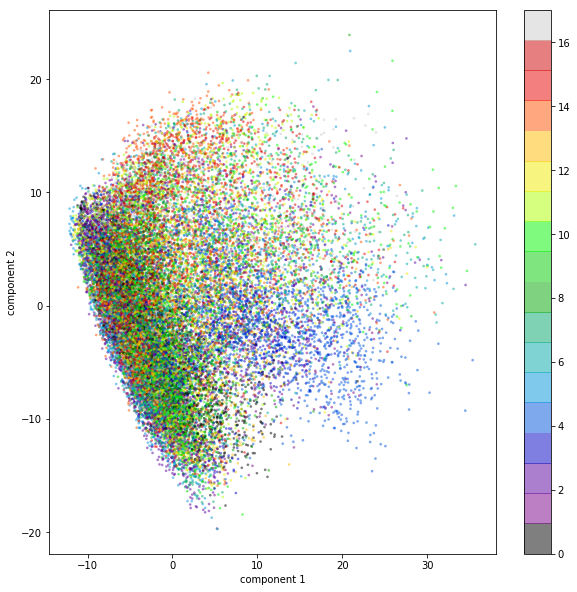

In [0]:
#2D plot of 18 different classes (Each color denotes a different class)

plt.figure(figsize=[10,10])
plt.scatter(pca_results_2[:, 0], pca_results_2[:, 1],
            c=train_labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 18), s = 7)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [0]:
pca_3=decomposition.PCA(n_components = 3)

pca_3.fit(train_dataset)

pca_results_3 = pca_3.transform(train_dataset)

pca_3.explained_variance_ratio_.cumsum()

array([0.06630147, 0.12544093, 0.17905304], dtype=float32)

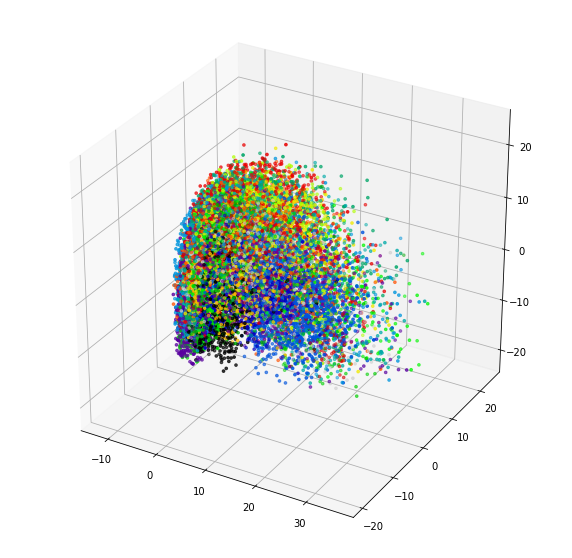

In [0]:
#3D plot of 18 different classes (Each color denotes a different class)

fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=pca_results_3[:, 0], ys= pca_results_3[:, 1], zs=pca_results_3[:, 2], zdir='z', 
           s=7,cmap=plt.cm.get_cmap('nipy_spectral', 18), c=train_labels, depthshade=True)


# Data Visualization - t-distributed Stochastic Neighbor Embedding

Now we apply t-distributed stochastic neighbor embedding(t-SNE) on the dataset. The dataset has 1024 features for each example. For the first step, we try to apply t-SNE and reduce the no. of components to two. In the second step, we reduce the components to three and make a 3D plot.

In [0]:
time_start = time.time()
tsne_2 = TSNE(n_components=2, verbose = 1)
tsne_results_2 = tsne_2.fit_transform(train_dataset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30600 samples in 10.664s...
[t-SNE] Computed neighbors for 30600 samples in 1854.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30600
[t-SNE] Computed conditional probabilities for sample 2000 / 30600
[t-SNE] Computed conditional probabilities for sample 3000 / 30600
[t-SNE] Computed conditional probabilities for sample 4000 / 30600
[t-SNE] Computed conditional probabilities for sample 5000 / 30600
[t-SNE] Computed conditional probabilities for sample 6000 / 30600
[t-SNE] Computed conditional probabilities for sample 7000 / 30600
[t-SNE] Computed conditional probabilities for sample 8000 / 30600
[t-SNE] Computed conditional probabilities for sample 9000 / 30600
[t-SNE] Computed conditional probabilities for sample 10000 / 30600
[t-SNE] Computed conditional probabilities for sample 11000 / 30600
[t-SNE] Computed conditional probabilities for sample 12000 / 30600
[t-SNE] Computed conditional probabilities for

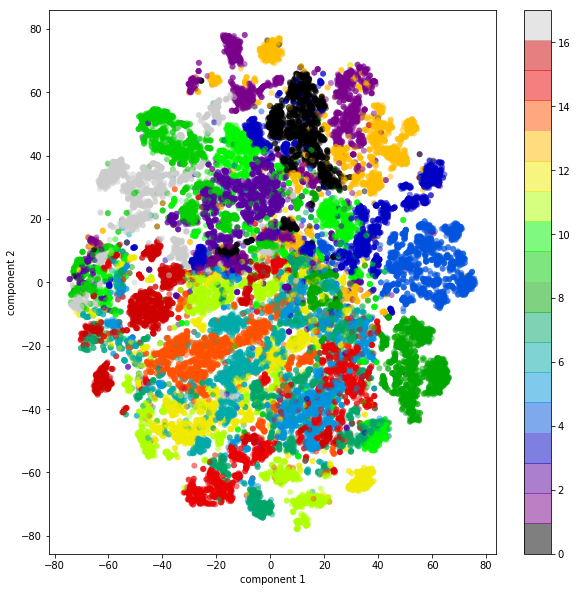

In [0]:
#2D plot of 18 different classes (Each color denotes a different class)

plt.figure(figsize=[10,10])
plt.scatter(tsne_results_2[:, 0], tsne_results_2[:, 1],
            c=train_labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 18))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [0]:
time_start = time.time()
tsne_3 = TSNE(n_components=3, verbose=1)
tsne_results_3 = tsne_3.fit_transform(train_dataset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30600 samples in 11.264s...
[t-SNE] Computed neighbors for 30600 samples in 1841.575s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30600
[t-SNE] Computed conditional probabilities for sample 2000 / 30600
[t-SNE] Computed conditional probabilities for sample 3000 / 30600
[t-SNE] Computed conditional probabilities for sample 4000 / 30600
[t-SNE] Computed conditional probabilities for sample 5000 / 30600
[t-SNE] Computed conditional probabilities for sample 6000 / 30600
[t-SNE] Computed conditional probabilities for sample 7000 / 30600
[t-SNE] Computed conditional probabilities for sample 8000 / 30600
[t-SNE] Computed conditional probabilities for sample 9000 / 30600
[t-SNE] Computed conditional probabilities for sample 10000 / 30600
[t-SNE] Computed conditional probabilities for sample 11000 / 30600
[t-SNE] Computed conditional probabilities for sample 12000 / 30600
[t-SNE] Computed conditional probabilities for

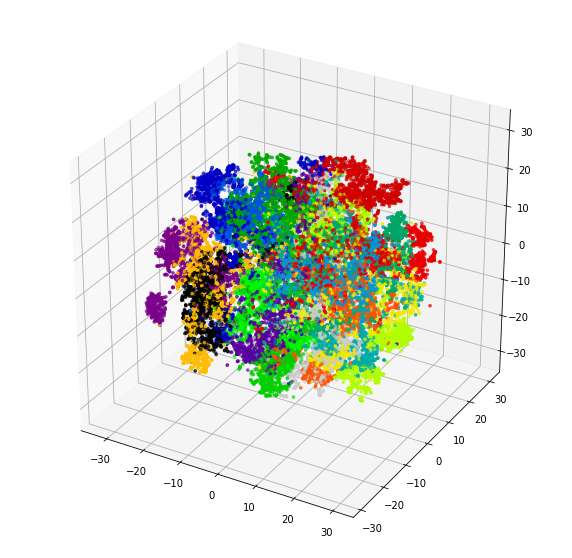

In [0]:
#3D plot of 18 different classes (Each color denotes a different class)

fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=tsne_results_3[:, 0], ys= tsne_results_3[:, 1], zs=tsne_results_3[:, 2], zdir='z',
           s=7,cmap=plt.cm.get_cmap('nipy_spectral', 18), c=train_labels, depthshade=True)

# Data Visualization - PCA + t-SNE

Here, we first use PCA to reduce the components to 75 and then use t-SNE to reduce components to 2 and 3 respectively

In [0]:
#Linear dimensionality reduction model
pca_75=decomposition.PCA(n_components = 75)

pca_75.fit(train_dataset)

pca_results_75 = pca_75.transform(train_dataset)

pca_75.explained_variance_ratio_.cumsum()

array([0.06630149, 0.12544096, 0.17905308, 0.22237234, 0.2641152 ,
       0.2950316 , 0.32441592, 0.35029718, 0.37418234, 0.39484724,
       0.41462344, 0.43373254, 0.4512779 , 0.46836644, 0.48510996,
       0.50130343, 0.5154907 , 0.52907765, 0.54232144, 0.55478513,
       0.5665552 , 0.57760924, 0.58843213, 0.59862596, 0.608648  ,
       0.6180484 , 0.6272317 , 0.63604724, 0.6445032 , 0.6525867 ,
       0.6603417 , 0.66786593, 0.67509204, 0.6821023 , 0.6888635 ,
       0.6955033 , 0.70206153, 0.7081705 , 0.7141635 , 0.71999335,
       0.7255617 , 0.7310264 , 0.7362245 , 0.74137247, 0.7464641 ,
       0.75143486, 0.7561606 , 0.7607936 , 0.76527137, 0.76969486,
       0.77392066, 0.777911  , 0.7817752 , 0.7856146 , 0.78938776,
       0.79309607, 0.79675394, 0.8002958 , 0.80381817, 0.8071095 ,
       0.8103086 , 0.8134257 , 0.8165277 , 0.81954694, 0.82245   ,
       0.8252998 , 0.8280812 , 0.8308349 , 0.8334398 , 0.8360129 ,
       0.83851606, 0.8409747 , 0.84338903, 0.84569097, 0.84797

In [0]:
time_start = time.time()
tsne_75_2 = TSNE(n_components=2, verbose=1)
tsne_results_75_2 = tsne_75_2.fit_transform(pca_results_75)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30600 samples in 0.122s...
[t-SNE] Computed neighbors for 30600 samples in 143.921s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30600
[t-SNE] Computed conditional probabilities for sample 2000 / 30600
[t-SNE] Computed conditional probabilities for sample 3000 / 30600
[t-SNE] Computed conditional probabilities for sample 4000 / 30600
[t-SNE] Computed conditional probabilities for sample 5000 / 30600
[t-SNE] Computed conditional probabilities for sample 6000 / 30600
[t-SNE] Computed conditional probabilities for sample 7000 / 30600
[t-SNE] Computed conditional probabilities for sample 8000 / 30600
[t-SNE] Computed conditional probabilities for sample 9000 / 30600
[t-SNE] Computed conditional probabilities for sample 10000 / 30600
[t-SNE] Computed conditional probabilities for sample 11000 / 30600
[t-SNE] Computed conditional probabilities for sample 12000 / 30600
[t-SNE] Computed conditional probabilities for s

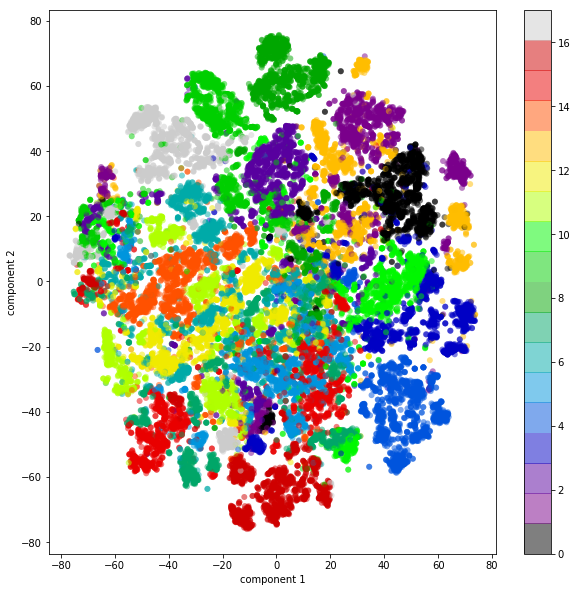

In [0]:
#2D plot of 18 different classes (Each color denotes a different class)

plt.figure(figsize=[10,10])
plt.scatter(tsne_results_75_2[:, 0], tsne_results_75_2[:, 1],
            c=train_labels, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 18))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [0]:
time_start = time.time()
tsne_75_3 = TSNE(n_components=3, verbose=1)
tsne_results_75_3 = tsne_75_3.fit_transform(pca_results_75)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30600 samples in 0.126s...
[t-SNE] Computed neighbors for 30600 samples in 141.714s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30600
[t-SNE] Computed conditional probabilities for sample 2000 / 30600
[t-SNE] Computed conditional probabilities for sample 3000 / 30600
[t-SNE] Computed conditional probabilities for sample 4000 / 30600
[t-SNE] Computed conditional probabilities for sample 5000 / 30600
[t-SNE] Computed conditional probabilities for sample 6000 / 30600
[t-SNE] Computed conditional probabilities for sample 7000 / 30600
[t-SNE] Computed conditional probabilities for sample 8000 / 30600
[t-SNE] Computed conditional probabilities for sample 9000 / 30600
[t-SNE] Computed conditional probabilities for sample 10000 / 30600
[t-SNE] Computed conditional probabilities for sample 11000 / 30600
[t-SNE] Computed conditional probabilities for sample 12000 / 30600
[t-SNE] Computed conditional probabilities for s

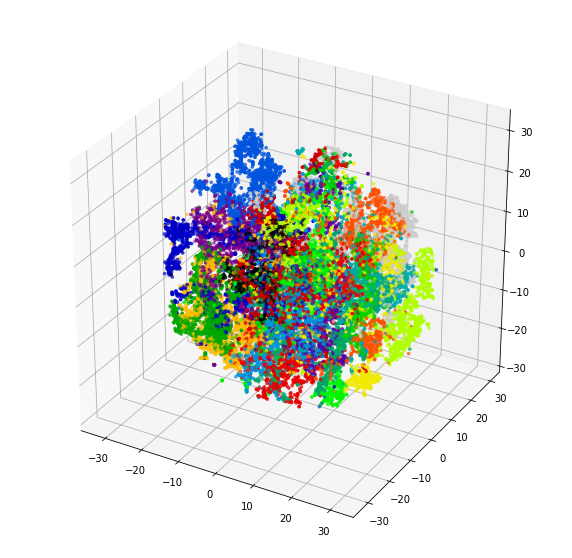

In [0]:
#3D plot of 18 different classes (Each color denotes a different class)

fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=tsne_results_75_3[:, 0], ys= tsne_results_75_3[:, 1], zs=tsne_results_75_3[:, 2], zdir='z',
           s=7,cmap=plt.cm.get_cmap('nipy_spectral', 18), c=train_labels, depthshade=True)